# Setup

---

The idea for the following project came from a [Medium post](https://medium.com/@dmytrosazonov/how-to-predict-stock-market-using-google-tensorflow-and-lstm-neural-network-81ccc41a22a8). We improve the Medium's code adding new models and new analysis. To do that, the group used as tools the [ChatGPT](https://chat.openai.com/) optimizations and the [Aurélien Geron's public notebooks](https://github.com/ageron/handson-ml2/blob/master/15_processing_sequences_using_rnns_and_cnns.ipynb)


In [2]:
import datetime as dt
import time as tm

# AI
import keras

# Graphics library
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

# Data preparation
from yahoo_fin import stock_info as yf

from utils import (
    last_time_step_mse,
    plot_learning_curves,
    plot_multiple_forecasts,
    plot_series,
)

## Data

--- 

#### Load Data From Yahoo API

In [3]:
tf.random.set_seed(42)

ANALYZED_YEARS = 5
STOCK = "GOOGL"
INTERVAL = "1d"
N_STEPS = 22  # working days of a month
EPOCHS = 50

In [4]:
init_df = yf.get_data(
    STOCK,
    start_date=(dt.date.today() - dt.timedelta(days=365 * ANALYZED_YEARS)).strftime(
        "%Y-%m-%d"
    ),
    end_date=tm.strftime("%Y-%m-%d"),
    interval=INTERVAL,
)
init_df.to_csv(f"./data/raw/{STOCK}_{ANALYZED_YEARS}Y_{INTERVAL}.csv")
init_df.head()

,open,high,low,close,adjclose,volume,ticker
2018-05-31,54.099998,55.500000,53.900002,55.000000,55.000000,79368000,GOOGL
2018-06-01,55.643501,56.908001,55.600498,56.750000,56.750000,63202000,GOOGL
2018-06-04,56.924999,57.893002,56.849998,57.652000,57.652000,44754000,GOOGL
2018-06-05,57.733002,58.055000,57.373001,57.550999,57.550999,32964000,GOOGL
2018-06-06,57.638500,57.735500,56.816002,57.347500,57.347500,34934000,GOOGL


In [5]:
# remove unused columns
init_df.drop(
    ["open", "high", "low", "adjclose", "ticker", "volume"], axis=1, inplace=True
)
init_df["date"] = init_df.index
init_df.reset_index(drop=True, inplace=True)

# Scale
scaler = MinMaxScaler()
init_df["close_norm"] = scaler.fit_transform(
    np.expand_dims(init_df["close"].values, axis=1)
)
init_df.to_csv(f"./data/processed/{STOCK}_{ANALYZED_YEARS}Y_{INTERVAL}.csv")

# Save scaled array
np.save(
    f"./data/processed/{STOCK}_{ANALYZED_YEARS}Y_{INTERVAL}_norm", init_df["close_norm"]
)

init_df.head()


,close,date,close_norm
0,55.000000,2018-05-31,0.057318
1,56.750000,2018-06-01,0.074713
2,57.652000,2018-06-04,0.083679
3,57.550999,2018-06-05,0.082675
4,57.347500,2018-06-06,0.080652


#### Visualization 

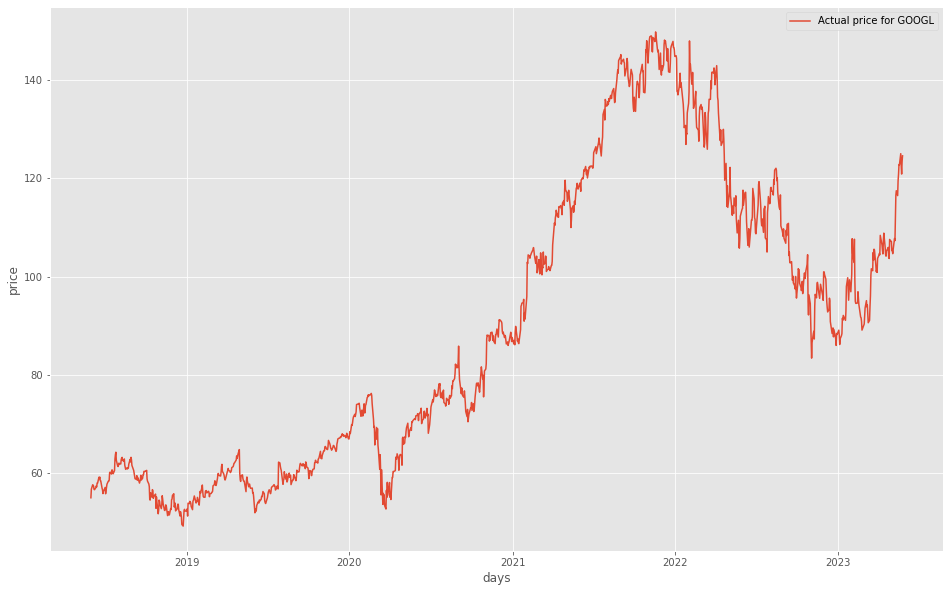

In [6]:
plt.style.use(style="ggplot")
plt.figure(figsize=(16, 10))
plt.plot(init_df["date"], init_df["close"])
plt.xlabel("days")
plt.ylabel("price")
plt.legend([f"Actual price for {STOCK}"])
plt.show()

#### Data split

In [7]:
data = np.load(f"./data/processed/{STOCK}_{ANALYZED_YEARS}Y_{INTERVAL}_norm.npy")

data = np.reshape(data[data.size % N_STEPS :], (data.size // N_STEPS, N_STEPS, 1))

X_train, y_train = (
    data[: int(data.shape[0] * 0.8), : N_STEPS - 1],
    data[: int(data.shape[0] * 0.8), -1],
)
X_test, y_test = (
    data[int(data.shape[0] * 0.8):, : N_STEPS - 1],
    data[int(data.shape[0] * 0.8):, -1],
)

## Models

---

#### Naive Forecasting

In [8]:
y_pred = X_test[:, -1]
np.mean(keras.losses.mean_squared_error(y_pred, y_test))

0.0005052313685704036

#### Linear Regression

In [9]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential(
    [keras.layers.Flatten(input_shape=[N_STEPS - 1, 1]), keras.layers.Dense(1)]
)

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=EPOCHS, validation_data=(X_test, y_test))
model.save(f"./models/LR_{STOCK}_{ANALYZED_YEARS}Y_{INTERVAL}-{N_STEPS}timeSteps")

Epoch 1/50
2/2 [==============================] - 1s 131ms/step - loss: 0.7280 - val_loss: 0.9119
Epoch 2/50
2/2 [==============================] - 0s 25ms/step - loss: 0.6908 - val_loss: 0.8652
Epoch 3/50
2/2 [==============================] - 0s 25ms/step - loss: 0.6552 - val_loss: 0.8196
Epoch 4/50
2/2 [==============================] - 0s 25ms/step - loss: 0.6220 - val_loss: 0.7755
Epoch 5/50
2/2 [==============================] - 0s 27ms/step - loss: 0.5862 - val_loss: 0.7331
Epoch 6/50
2/2 [==============================] - 0s 29ms/step - loss: 0.5544 - val_loss: 0.6917
Epoch 7/50
2/2 [==============================] - 0s 26ms/step - loss: 0.5250 - val_loss: 0.6517
Epoch 8/50
2/2 [==============================] - 0s 23ms/step - loss: 0.4956 - val_loss: 0.6138
Epoch 9/50
2/2 [==============================] - 0s 25ms/step - loss: 0.4646 - val_loss: 0.5778
Epoch 10/50
2/2 [==============================] - 0s 26ms/step - loss: 0.4379 - val_loss: 0.5429
Epoch 11/50
2/2 [===========

INFO:tensorflow:Assets written to: ./models/LR_GOOGL_5Y_1d-22timeSteps\assets


INFO:tensorflow:Assets written to: ./models/LR_GOOGL_5Y_1d-22timeSteps\assets


1/1 [==============================] - 0s 19ms/step - loss: 0.0170


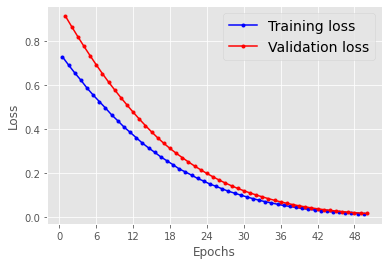

In [10]:
model.evaluate(X_test, y_test)
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

1/1 [==============================] - 0s 60ms/step


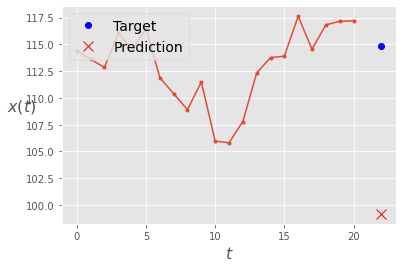

In [11]:
y_pred = model.predict(X_test)
plot_series(scaler.inverse_transform([X_test[0, :,0]])[0], scaler.inverse_transform(np.array([[y_test[0,0]]])), scaler.inverse_transform(np.array([[y_pred[0,0]]])), n_steps=N_STEPS)
plt.show()

#### Deep RNN

In [12]:
model = keras.models.Sequential(
    [
        keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
        keras.layers.SimpleRNN(20),
        keras.layers.Dense(1),
    ]
)

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=EPOCHS, validation_data=(X_test, y_test))
model.save(f"./models/RNN_{STOCK}_{ANALYZED_YEARS}Y_{INTERVAL}-{N_STEPS}timeSteps")


Epoch 1/50
2/2 [==============================] - 2s 269ms/step - loss: 0.0247 - val_loss: 0.0113
Epoch 2/50
2/2 [==============================] - 0s 31ms/step - loss: 0.0193 - val_loss: 0.0067
Epoch 3/50
2/2 [==============================] - 0s 31ms/step - loss: 0.0098 - val_loss: 0.0147
Epoch 4/50
2/2 [==============================] - 0s 32ms/step - loss: 0.0069 - val_loss: 0.0047
Epoch 5/50
2/2 [==============================] - 0s 32ms/step - loss: 0.0063 - val_loss: 0.0031
Epoch 6/50
2/2 [==============================] - 0s 30ms/step - loss: 0.0073 - val_loss: 0.0104
Epoch 7/50
2/2 [==============================] - 0s 31ms/step - loss: 0.0036 - val_loss: 0.0147
Epoch 8/50
2/2 [==============================] - 0s 31ms/step - loss: 0.0041 - val_loss: 0.0081
Epoch 9/50
2/2 [==============================] - 0s 30ms/step - loss: 0.0026 - val_loss: 0.0028
Epoch 10/50
2/2 [==============================] - 0s 33ms/step - loss: 0.0031 - val_loss: 0.0022
Epoch 11/50
2/2 [===========

INFO:tensorflow:Assets written to: ./models/RNN_GOOGL_5Y_1d-22timeSteps\assets


INFO:tensorflow:Assets written to: ./models/RNN_GOOGL_5Y_1d-22timeSteps\assets


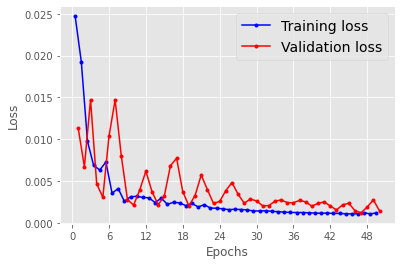

In [13]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

1/1 [==============================] - 0s 176ms/step


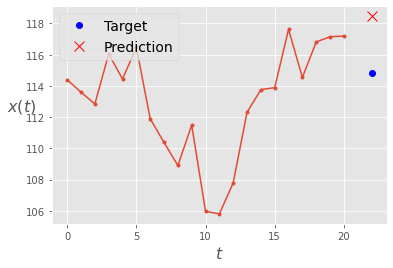

In [14]:
y_pred = model.predict(X_test)
plot_series(scaler.inverse_transform([X_test[0, :,0]])[0], scaler.inverse_transform(np.array([[y_test[0,0]]])), scaler.inverse_transform(np.array([[y_pred[0,0]]])), n_steps=N_STEPS)
plt.show()